In [39]:
import requests
import json
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import itertools
import math
import queue
from timeit import default_timer as timer

#### Tools

In [6]:
flatten = itertools.chain.from_iterable

def req(attr):
    url = 'http://api.slowosiec.clarin-pl.eu/plwordnet-api/' + attr
    r = requests.get(url)
    return json.loads(r.text)

def get_meaning(word):
    meanings = req(f'senses/search?lemma={word}')['content']
    meanings = [(m['id'], m['domain']['description']) for m in meanings]
    return meanings

def get_sysnet_id(w_id):
    return req(f'senses/{w_id}/synset')

def get_synset_sense(s_id):
    return req(f'synsets/{s_id}/senses')
    
def get_synonyms(word):
    meaning_ids = [m_id for  (m_id, _) in get_meaning(word)]
    synsets = [get_sysnet_id(w_id)['id'] for w_id in meaning_ids]
    synsets_m = [get_synset_sense(s_id) for s_id in synsets]
    synonyms = set()
    for s_m in synsets_m:
        for meaning in s_m:
            m = meaning['lemma']
            synonyms.add((m['id'], m['word']))
    return synonyms   

def get_relation_from(s_id):
    return req(f'synsets/{s_id}/relations/from')

def get_relation_all(s_id):
    return req(f'synsets/{s_id}/relations')

def find_relation(node, synset, already_found, relation_type, max_depth=math.inf):
    res = []
    res.append([node, synset])
    for synset_id in synset:
        syn_to = get_relation_from(synset_id)
        syn_to = [s['synsetTo']['id'] for s in syn_to if s['relation']['name'] == relation_type]
        res.append([synset_id, syn_to])
        
        candidates = [s_id for s_id in syn_to if s_id not in already_found]
        if len(candidates) > 0 and max_depth > 0:
            res += find_relation(synset_id, candidates, already_found, relation_type, max_depth-1)
        already_found.update(candidates)
    return res

def draw_relation_graph(relation_type, word, max_depth=math.inf):
    wd_m = get_meaning(word)
    wd_id = wd_m[0][0]
    wd_synsets = [get_sysnet_id(wd_id)['id']]
    wd_hyp = list(find_relation(wd_synsets[0], wd_synsets, set(wd_synsets), relation_type=relation_type, max_depth=max_depth))
    wd_hyp_ids = set(flatten([[h_id]+to_ids for h_id, to_ids in wd_hyp]))

    wd_hyp_meanings = dict()
    for h_id in wd_hyp_ids:
        meanings = [m['lemma']['word'] for m in get_synset_sense(h_id)]
        meanings = '|'.join(map(str, meanings)) 
        wd_hyp_meanings[h_id] = meanings
    
    edges = []
    for from_h, ends in wd_hyp:
        for to_h in ends:
            edges.append((from_h, to_h))

    edges = [(wd_hyp_meanings[e1], wd_hyp_meanings[e2]) for (e1, e2) in edges]

    G = nx.DiGraph()
    G.add_edges_from(edges)

    plt.figure(figsize=(16, 16))
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G,pos, labels={node:node for node in G.nodes()}, arrowsize=20)



## Find all meanings of the "szkoda" noun and display all their synonyms.

In [234]:
sz_meanings = get_meaning("szkoda")
sz_meanings

[(8769, 'plWN miejsca i umiejscowienie'),
 (8770, 'plWN czasowniki wyrażające uczucia'),
 (8771, 'plWN posiadanie i jego zmiana')]

In [235]:
sz_synonyms = get_synonyms("szkoda")
sz_synonyms

{(243080, 'strata'),
 (249489, 'szkoda'),
 (270658, 'uszczerbek'),
 (270916, 'utrata'),
 (300080, 'żal'),
 (300109, 'żałować')}

## Find closure of hyponymy relation for the first meaning of the "wypadek drogowy" expression. Create diagram of the relations as a directed graph.

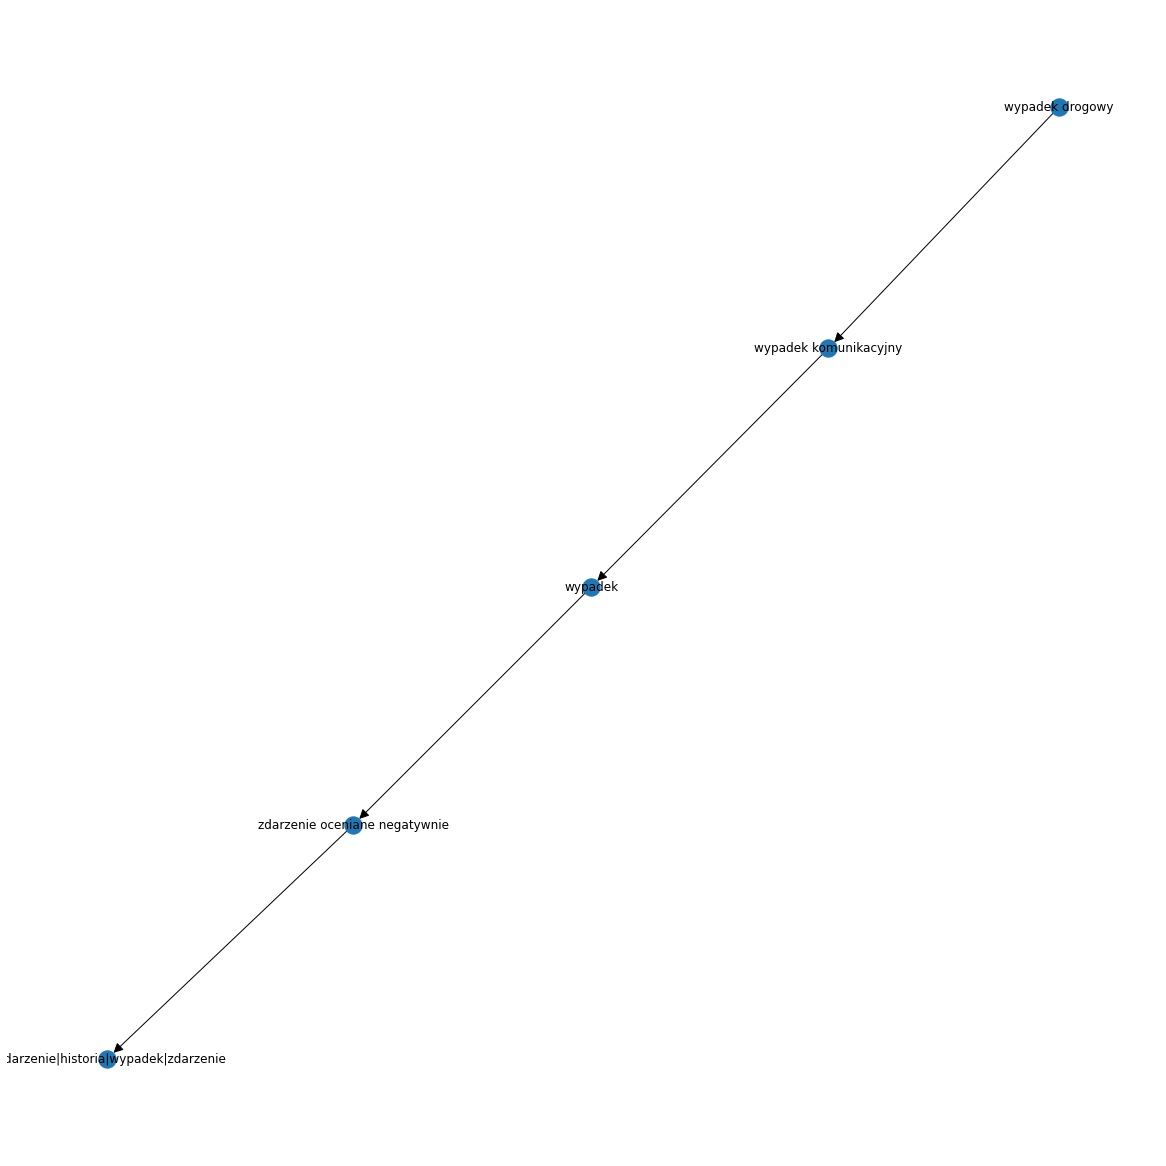

In [244]:
draw_relation_graph("hiponimia", "wypadek drogowy")

## Find direct hyponyms of wypadek noun.

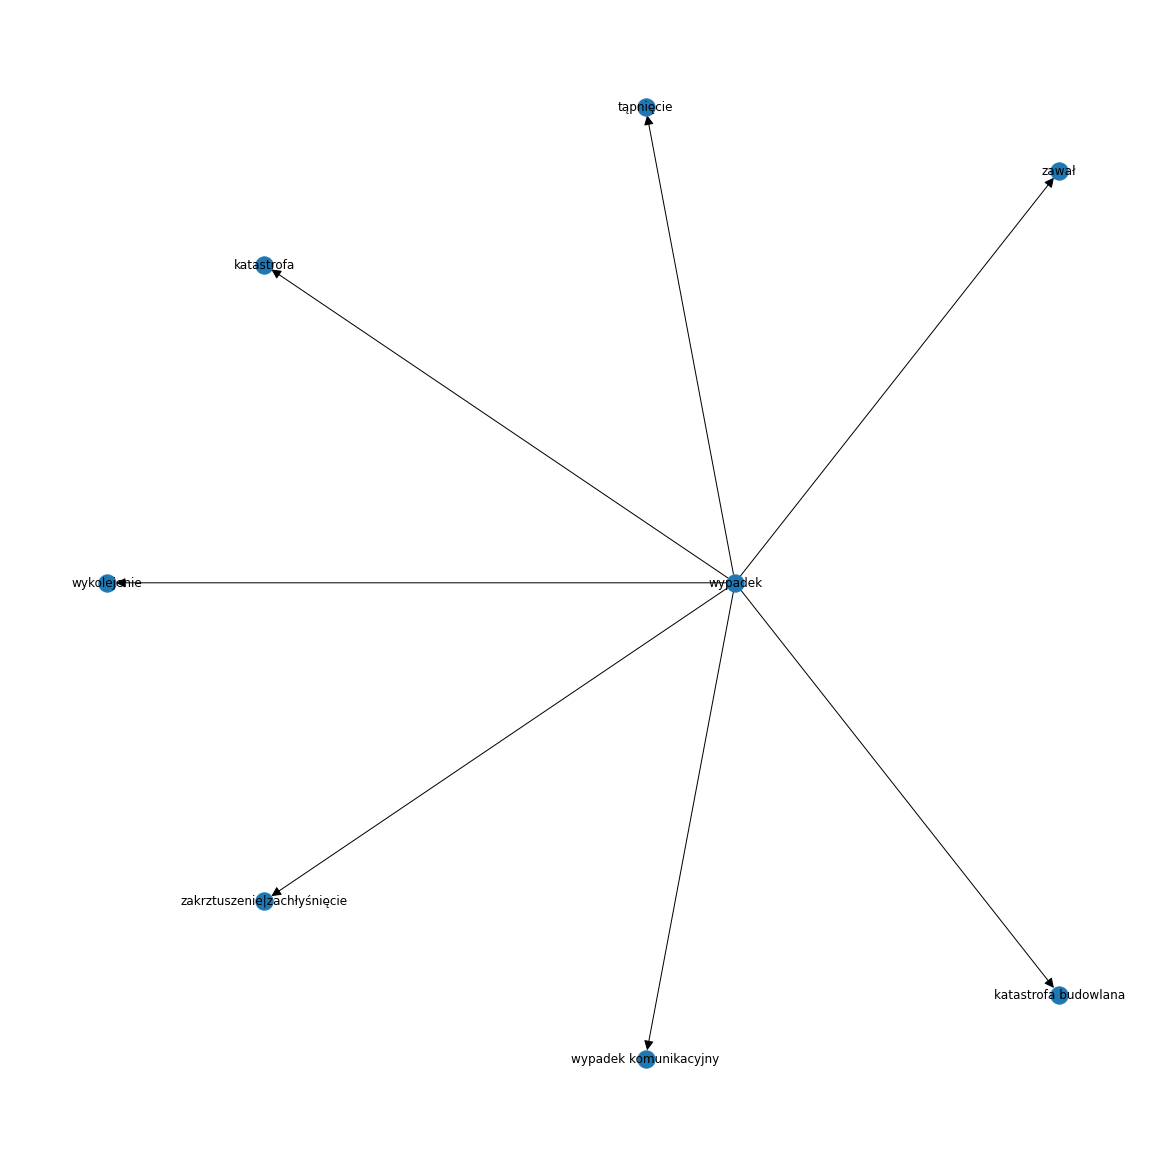

In [248]:
draw_relation_graph("hiperonimia", "wypadek", max_depth=0)

## Find second-order hyponyms of the same noun.

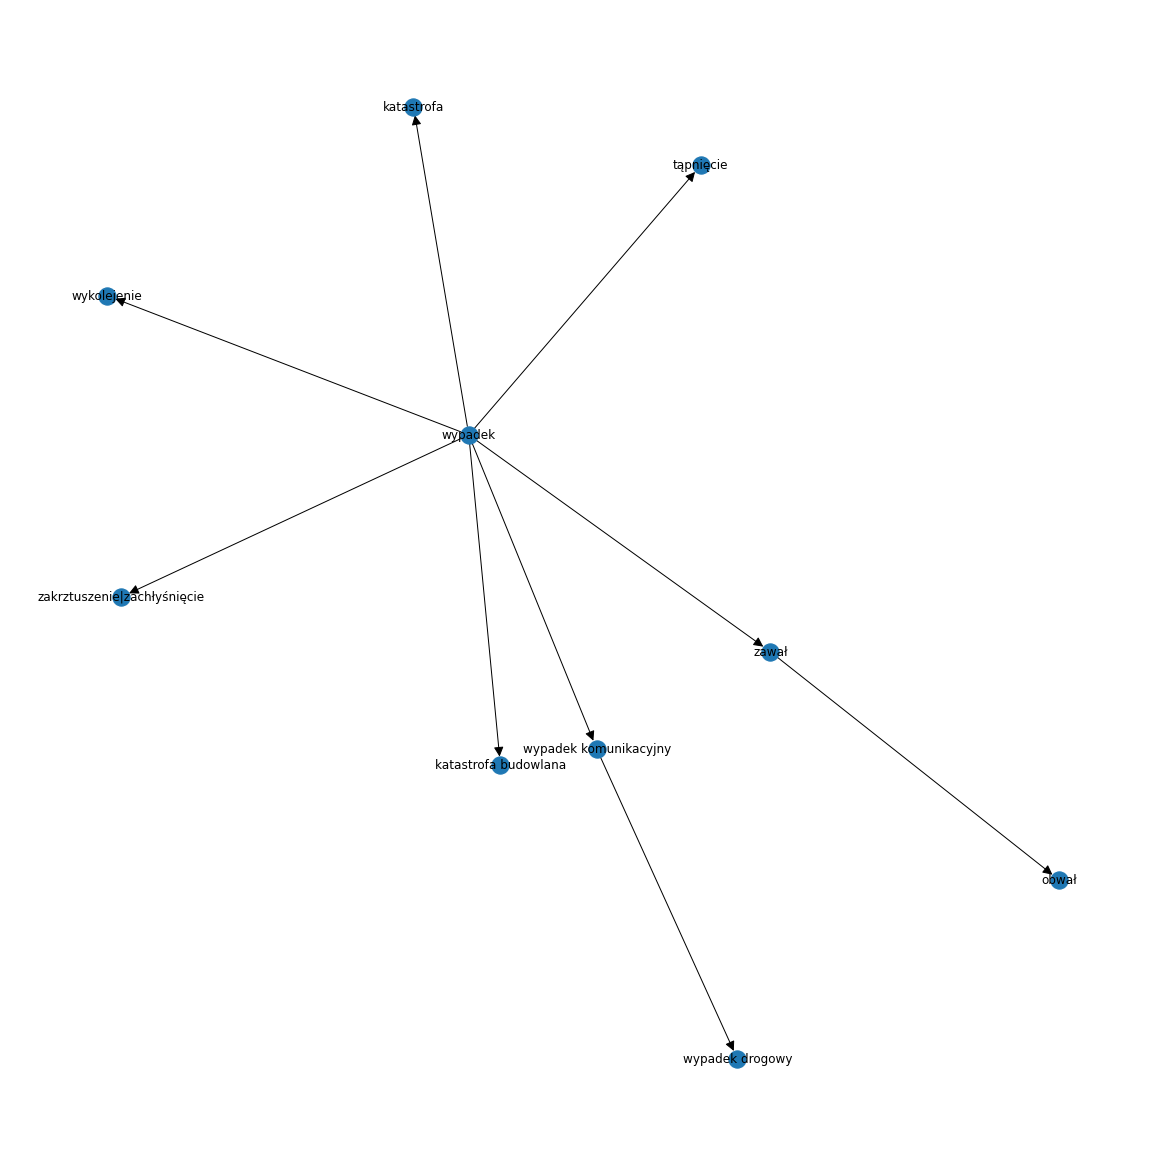

In [249]:
draw_relation_graph("hiperonimia", "wypadek", max_depth=1)

## Display as a directed graph (with labels for the edges) semantic relations between the following groups of lexemes:
* szkoda2, strata1, uszczerbek1, szkoda majątkowa1, uszczerbek na zdrowiu1, krzywda1, niesprawiedliwość1, nieszczęście2.
* wypadek1, wypadek komunikacyjny1, kolizja2, zderzenie2, kolizja drogowa1, bezkolizyjny2, katastrofa budowlana1, wypadek drogowy1.

In [356]:
def create_group_relation_graph(group):
    edges = []
    edge_labels = {}
    vertex_labels = {}
    
    for word, meaning_n in group:
        w_meanings = get_meaning(word)
        if len(w_meanings) > meaning_n:
            meaning = w_meanings[meaning_n]
            meaning_id = meaning[0]
            from_id = get_sysnet_id(meaning_id)['id']
            from_meanings = [m['lemma']['word'] for m in get_synset_sense(h_id)]
            from_meanings = '|'.join(map(str, from_meanings)) 
            
            vertex_labels[from_id] = from_meanings
            vertex_labels[meaning_id] = word+str(meaning_n)
            edge = (meaning_id, from_id)
            edge_labels[edge] = "synset"
            edges.append(edge)

            for relation in get_relation_from(from_id):
                to_id = relation['synsetTo']['id']
                to_meanings = [m['lemma']['word'] for m in get_synset_sense(to_id)]
                to_meanings = '|'.join(map(str, to_meanings)) 
                edge = (from_id, to_id)
                relation_name = relation['relation']['name']
                
                edges.append(edge)
                edge_labels[edge] = relation_name
                vertex_labels[to_id] = to_meanings

                
    G = nx.DiGraph()
    G.add_edges_from(edges)

    plt.figure(figsize=(16, 16))
    pos = graphviz_layout(G)
    nx.draw(G,pos, arrowsize=20)
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
    nx.draw_networkx_labels(G, pos, vertex_labels, font_size=10)

In [357]:
group1 = [('szkoda', 1), ('strata', 0), ('uszczerbek', 0), ('szkoda majątkowa', 0), ('uszczerbek na zdrowiu', 0), 
          ('krzywda', 0), ('niesprawiedliwość', 0), ('nieszczęście', 1)]
group2 = [('wypadek', 0), ('wypadek komunikacyjny', 0), ('kolizja', 1), ('zderzenie', 1), ('kolizja drogowa', 0),
          ('bezkolizyjny', 1), ('katastrofa budowlana', 0), ('wypadek drogowy', 0)]

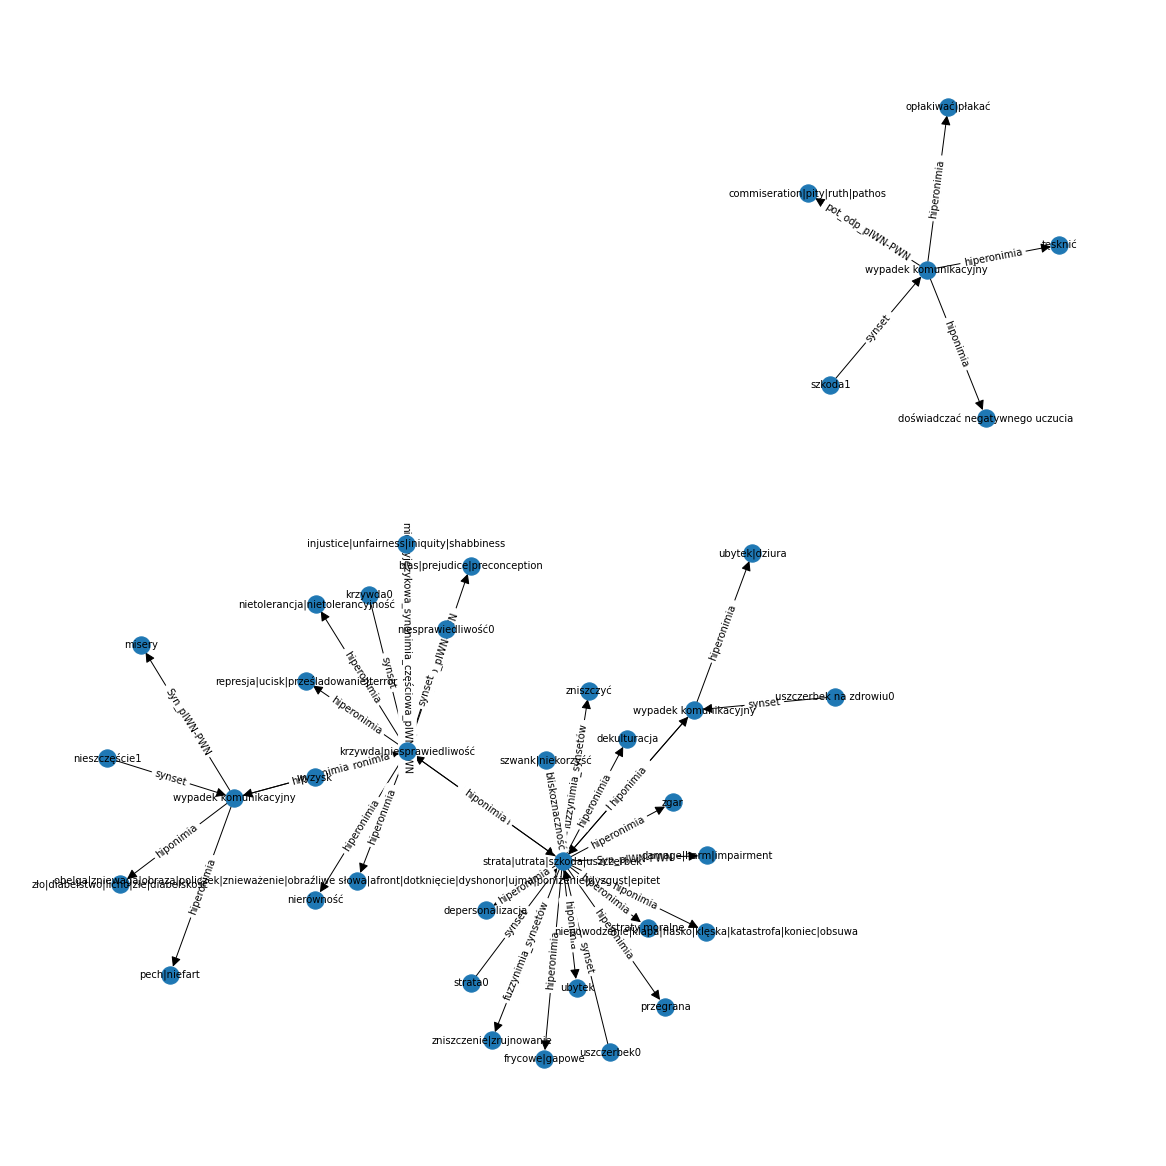

In [358]:
create_group_relation_graph(group1)

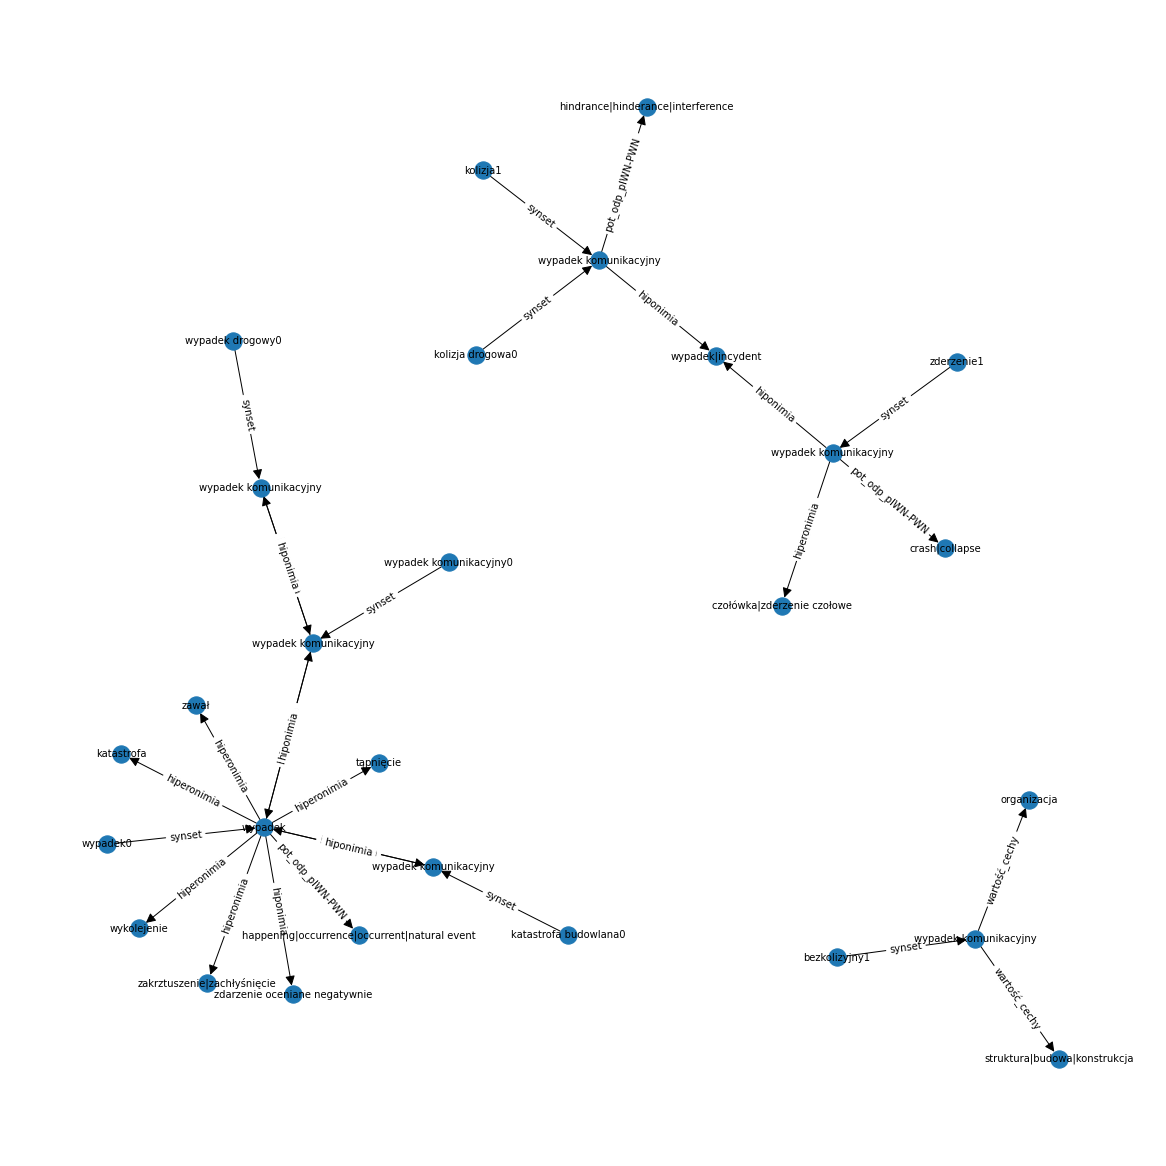

In [359]:
create_group_relation_graph(group2)

## Find the value of Leacock-Chodorow semantic similarity measure between following pairs of lexemes:
* szkoda2 - wypadek1,
* kolizja2 - szkoda majątkowa1,
* nieszczęście2 - katastrofa budowlana1.

In [4]:
pairs = [ 
    [('szkoda',1), ('wypadek',0)] , 
    [('kolizja',1), ('szkoda majątkowa',0)] , 
    [('nieszczęście',1), ('katastrofa budowlana',0)]
]

In [68]:
def lc_similarity(distance, max_distance):
    return -math.log((distance) / (2.0 * max_distance))

def find_sp(w1, w2):
    w1_word, w1_meaning_n = w1
    w2_word, w2_meaning_n = w2
    w1_meanings = get_meaning(w1_word)
    w2_meanings = get_meaning(w2_word)
    
    if len(w1_meanings) > w1_meaning_n:
        w1_id, w1_meaning = w1_meanings[w1_meaning_n]
    else:
        return -1
    if len(w2_meanings) > w2_meaning_n:
        w2_id, w2_meaning = w2_meanings[w2_meaning_n]
    else:
        return -1
    
    s_from = get_sysnet_id(w1_id)['id']
    s_to = get_sysnet_id(w2_id)['id']
        
    return sp(s_from, s_to)


def sp(s1,s2,max_distance = 50):
    pq = queue.PriorityQueue()
    pq.put((0,s1))
    visited = set()
    
    while not pq.empty():
        distance, synset_id = pq.get()
        if synset_id not in visited:
            visited.add(synset_id)
            relations = get_relation_all(synset_id)
            
            for relation in relations:
                s_from, s_to = relation['synsetFrom']['id'], relation['synsetTo']['id']
                
                if s_from == s2 or s_to == s2:
                    return distance + 1
                if distance < max_distance:
                    pq.put((distance+1, s_from))
                    pq.put((distance+1, s_to))
    return -1

def find_max_depth(word, meaning_n):
    print(f'Counting max_depth for: {word}')
    start = timer()
    meanings = get_meaning(word)
    if len(meanings) <= meaning_n:
        return 1
    meaning, _ = meanings[meaning_n]
    synset = get_sysnet_id(meaning)['id']
    synsets = [synset]
    lvl = 0
    already_checked = []
    while len(synsets) > 0:
        print(f'lvl: {lvl} synsets: {len(synsets)}')
        lvl_synsets = [x for x in synsets]
        synsets = []
        for synset in lvl_synsets:
            if synset not in already_checked:
                relations = get_relation_from(synset)
                for relation in relations:
                    if relation['relation']['name'] == 'hiponimia':
                        to = relation['synsetTo']['id']
                        if to not in already_checked and to not in synsets:
                            synsets.append(to)
                already_checked.append(synset)
        lvl += 1
    end = timer()
    print(f'Elapsed time: {(end - start)}s')
    return lvl
        

In [70]:
for pair in pairs:
    w1, w2 = pair
    max_depth = max(find_max_depth(*w1), find_max_depth(*w2))
    shortest_path = find_sp(*pair)
    pair_s = (pair[0][0], pair[1][0])
    if shortest_path < 0:
        print(f"{pair_s} \n\t Couldn't find connection.\n")
    else:
        lc = lc_similarity(shortest_path, max_depth)
        print(f"{pair_s} \n\t shortest path: {shortest_path} \n\t Leacock-Chodorow semantic similarity: {lc}\n")

Counting max_depth for: szkoda
lvl: 0 synsets: 1
lvl: 1 synsets: 1
lvl: 2 synsets: 1
lvl: 3 synsets: 1
lvl: 4 synsets: 2
lvl: 5 synsets: 2
Elapsed time: 2.6204076390004047s
Counting max_depth for: wypadek
lvl: 0 synsets: 1
lvl: 1 synsets: 1
lvl: 2 synsets: 1
Elapsed time: 2.1223081409998485s
('szkoda', 'wypadek') 
	 shortest path: 5 
	 Leacock-Chodorow semantic similarity: 0.8754687373538999

Counting max_depth for: kolizja
lvl: 0 synsets: 1
lvl: 1 synsets: 1
lvl: 2 synsets: 1
Elapsed time: 2.7346028769998156s
Counting max_depth for: szkoda majątkowa
('kolizja', 'szkoda majątkowa') 
	 Couldn't find connection.

Counting max_depth for: nieszczęście
lvl: 0 synsets: 1
lvl: 1 synsets: 1
lvl: 2 synsets: 2
lvl: 3 synsets: 2
lvl: 4 synsets: 1
lvl: 5 synsets: 1
Elapsed time: 6.881519947000015s
Counting max_depth for: katastrofa budowlana
lvl: 0 synsets: 1
lvl: 1 synsets: 1
lvl: 2 synsets: 1
lvl: 3 synsets: 1
Elapsed time: 3.787318261999644s
('nieszczęście', 'katastrofa budowlana') 
	 shortest 

## Questions/problems:
* #### What is the necessary step to use the knowlege from dictionaries such as WordNet?
Aby używać słowników takich jak WordNet niezbędna jest znajomość ich budowy, struktur oraz połączeń między nimi. Następnie musimy zaznajomić się z API, który w przypadku takim jak WordNet jest bardzo rozbudowane.
* #### Assess the value of WordNet as a resource for representing the sense of sentences (not words in isolation).
W WordNet jest bezsprzecznie ogromna ilość informacji o znaczeniu słów, natomiast jako sens całych zdań nie sprawdziłby się według mnie, ponieważ nie jest w stanie on określić kontekstu, ani wnioskować które znaczenie poszczególnych słow dotyczy naszego zdania.
* #### Discuss the problmes comming from using structured knowledge resources such as WordNet.
Jednym z problemów, które napotkałem jest struktura synsetów. Częstym przypadkiem jest gdy jedno słowo należy do kilku synsetów w zależności od swojego znaczenia, nie jest jednak możliwe zdefiniowanie takiego znaczenia by następnie w automatyczny sposób szukać powiązań. Musimy ręcznie wybrać znaczenie słowa z listy, a następnie w odniesieniu do tego znaczenia szukać sysnetów.